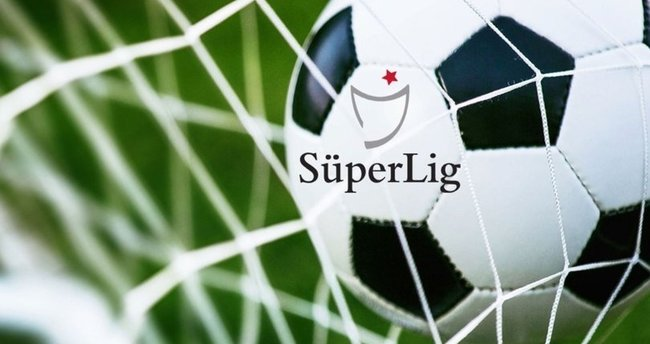

Geçen yıl Şampiyonlar Ligi için yaptığım benzer çalışmayı bu linke bulabilirsiniz: https://www.kaggle.com/cankumru/champions-league-19-20-group-standings-prediction

In this study, I will try to predict the match outcomes, thus the standings in Turkish Süper Lig season 2020-2021 by developing a statistical model that uses player (actually team) ratings to determine the outcome of the match.

Bu çalışmamda, FIFA 20/21 oyunundaki oyuncu (dolayısıyla takım) istatistiklerini kullanarak oluşturacağım istatiksel modelde, 2020-2021 sezonu sıralaması tahmininde bulunacağım. Bu projedeki bir diğer amacım örnek olarak bir kaç veri manipülasyonu operasyonununu ve sınıflandırmada kullanılan K Nearest Neighbor modelini göstermek. Bunun için satırlara küçük notlar da ekledim, umarım benzer çalışmalar için faydalı olur. 

**1. Kullanılacak veri setleri:** 

* FIFA 20 oyuncu verileri
* FIFA 21 oyuncu verileri
* 2019-2020 sezonu 9 Avrupa Liginden maç sonuçları (3000'den fazla maç)

**2. Geliştirilecek modeller:** 
* Bireysel oyuncu özelliklerinin kullanılması ile oluşturduğum takım istatistikleri veri seti ile 2019-2020 sezonu maç sonuçlarını birleştirerek bir tahminleme modeli oluşturacağım
* Model eğitimi tamamlandıktan sonra, bu modeli, FIFA 21'den elde ettiğim takım istatistiklerini ve bu yılın Süper Lig fikstrünü kullanarak maç sonuçlarını tahmin etmekte kullanacağım
* Yaklaşım olarak, bir maçın 3 farklı sonucu olabileceği gerçeğinden yola çıkarak bir sınıflandırma modeli kullanmam gerekiyor. Bunun için, K Nearest Neighbor kullanacağım (Decision Trees, Random Forest veya ANN algoritmalarını denemeyeceğim, fakat bunlar da kullanılarak model oluşturulabilir)

**3. Beklenen sonuç:** 
* Çalışmanın sonunda, takımların toplam puanları ve dolasıyla sıralama tahminlerini elde etmiş olacağız

İşe koyulalım ve tuttuğumuz takımın bu yıl kaçıncı olabileceğini tahmin edelim :)

In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read FIFA 20 and FIFA 21 datasets
fifa20 = pd.read_csv("../input/fifa-20-complete-player-dataset/fifa20_data.csv")
fifa21 = pd.read_csv("../input/fifa-21-complete-player-dataset/fifa21_male2.csv")

# Sneak peek at FIFA 20 columns which we will use in our training
fifa20.columns

In [ ]:
# Find the columns and drop them in FIFA 20 that does not appear in FIFA 21, so that we won't be training 
# those at all
df21_20 = fifa21.columns.difference(fifa20.columns)
df20_21 = fifa20.columns.difference(fifa21.columns)

# Drop different columns between two datasets and get the exact same set of columns for both
fifa20_df = fifa20.drop(fifa20[df20_21],axis=1)
fifa21_df = fifa21.drop(fifa21[df21_20],axis=1)

# Drop other unnecessary columns
fifa20_df = fifa20_df.drop(fifa20_df[['ID','foot','Joined','Loan Date End','Wage',
                                      'Release Clause','Growth','A/W','D/W','W/F','Total Stats','Base Stats','SM',
                                     'IR','Height','Weight','Value','BOV','BP']],axis=1)

fifa21_df = fifa21_df.drop(fifa21_df[['ID','foot','Joined','Loan Date End','Wage',
                                      'Release Clause','Growth','A/W','D/W','W/F','Total Stats','Base Stats','SM',
                                     'IR','Height','Weight','Value','BOV','BP']],axis=1)

# Get Goalkeeper stats only to calculate Goalkeeping stats for each team
gk_20 = fifa20_df[fifa20_df['Position']=='GK']
gk_21 = fifa21_df[fifa21_df['Position']=='GK']

# Get only GK related columns and add GK prefix to separate them
gk_20_df = gk_20[['Name','Age','Club','Goalkeeping','GK Diving','GK Handling',
                 'GK Kicking','GK Positioning','GK Reflexes']]
gk_20_df.columns = [str(col) + ' GK' for col in gk_20_df.columns]
gk_21_df = gk_21[['Name','Age','Club','Goalkeeping','GK Diving','GK Handling',
                 'GK Kicking','GK Positioning','GK Reflexes']]
gk_21_df.columns = [str(col) + ' GK' for col in gk_21_df.columns]

# Get the best GK in each team
gk_20_teams  = gk_20_df.loc[gk_20_df.groupby('Club GK')['Goalkeeping GK'].idxmax()]
gk_21_teams  = gk_21_df.loc[gk_21_df.groupby('Club GK')['Goalkeeping GK'].idxmax()]

# Repeat the same for non-GK player, except getting best players in each position 
not_gk_20 = fifa20_df[fifa20_df['Position']!='GK']
not_gk_21 = fifa21_df[fifa21_df['Position']!='GK']

# Drop Goalkeeping related columns
not_gk_20_df = not_gk_20.drop(['Goalkeeping','GK Diving','GK Handling','GK Kicking','GK Positioning',
                               'GK Reflexes'],axis=1)
not_gk_21_df = not_gk_21.drop(['Goalkeeping','GK Diving','GK Handling','GK Kicking','GK Positioning',
                               'GK Reflexes'],axis=1)

# Our aim is to reveal an overall score for each Club using individual players' scores
# Thus, I grouped the players by club and took a mean of each score in each column to calculate club overalls
not_gk_20_teams = not_gk_20_df.groupby('Club').mean().reset_index()
not_gk_21_teams = not_gk_21_df.groupby('Club').mean().reset_index()

# Finally merge GK and non-GK related scores
teams_20 = pd.merge(not_gk_20_teams,gk_20_teams,'left',left_on='Club', right_on='Club GK').drop(['Name GK','Club GK'],axis=1)
teams_21 = pd.merge(not_gk_21_teams,gk_21_teams,'left',left_on='Club', right_on='Club GK').drop(['Name GK','Club GK'],axis=1)

# Check for potential NAs in both datasets
teams_20.isnull().sum()
teams_21.isnull().sum()

In [ ]:
# We have 244 clubs that do not have scores, most probably due to some missing player in the dataset.
# Let's find those clubs
teams_21[teams_21['Age GK'].isnull()]['Club'].unique()

# Clubs here are not included in FIFA 20 set anyway to train the model, and for Turkish Super Lig predictions
# we only miss few clubs, that we will deal on the next steps. I'll just remove clubs with NA values

teams_21 = teams_21.dropna()

# Read in match results from 2019-2020 season from 9 different European league
uk = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'E0')
be = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'B1')
fr = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'F1')
de = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'D1')
it = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'I1')
es = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'SP1')
nt = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'N1')
pt = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'P1')
tr = pd.read_excel("../input/all-euro-matches/all-euro-data-2019-2020.xlsx", sheet_name = 'T1')

# There are some discrepancies between match results dataset and FIFA 20/21 dataset
# We'll adjust the names in match results to those in FIFA datasets
# This is a manual-intensive job, so feel free to use the code below for your work

uk_df = uk.replace({'Man United':'Manchester United','West Ham':'West Ham United','Tottenham':'Tottenham Hotspur','Leicester':'Leicester City',
                   'Newcastle':'Newcastle United','Brighton':'Brighton & Hove Albion','Norwich':'Norwich City','Man City':'Manchester City',
                    'Wolves':'Wolverhampton Wanderers'})

be_df = be.replace({'Genk':'KRC Genk','Cercle Brugge':'KSV Cercle Brugge','St Truiden':'Sint-Truidense VV','Waregem':'SV Zulte-Waregem',
                   'Anderlecht':'RSC Anderlecht','Charleroi':'Sporting de Charleroi','Eupen':'KAS Eupen','Club Brugge':'Club Brugge KV',
                   'Standard':'Standard de Liège','Kortrijk':'KV Kortrijk','Oostende':'KV Oostende','Mechelen':'KV Mechelen',
                   'Gent':'KAA Gent','Mouscron':'Royal Excel Mouscron','Antwerp':'Royal Antwerp FC'})

fr_df = fr.replace({'Monaco':'AS Monaco','Marseille':'Olympique de Marseille','Angers':'Angers SCO','Brest':'Stade Brestois 29',
                   'Dijon':'Dijon FCO','Montpellier':'Montpellier HSC','Nice':'OGC Nice','Lille':'LOSC Lille','Strasbourg':'RC Strasbourg Alsace',
                   'Paris SG':'Paris Saint-Germain','Lyon':'Olympique Lyonnais','Nantes':'FC Nantes','Amiens':'Amiens SC',
                   'Bordeaux':'FC Girondins de Bordeaux','Metz':'FC Metz','Nimes':'Nîmes Olympique','Toulouse':'Toulouse Football Club',
                    'St Etienne':'AS Saint-Étienne','Reims':'Stade de Reims','Rennes':'Stade Rennais FC'})

de_df = de.replace({'Bayern Munich':'FC Bayern München','Dortmund':'Borussia Dortmund','Freiburg':'SC Freiburg','Leverkusen':'Bayer 04 Leverkusen',
                   'Werder Bremen':'SV Werder Bremen','Wolfsburg':'VfL Wolfsburg',"M'gladbach":'Borussia Mönchengladbach',
                   'Ein Frankfurt':'Eintracht Frankfurt','Union Berlin':'1. FC Union Berlin','FC Koln':'1. FC Köln','Augsburg':'FC Augsburg',
                   'Fortuna Dusseldorf':'Fortuna Düsseldorf','Hoffenheim':'TSG 1899 Hoffenheim','Mainz':'1. FSV Mainz 05','Paderborn':'SC Paderborn 07',
                   'Schalke 04':'FC Schalke 04','Hertha':'Hertha BSC'})

it_df = it.replace({'Spal':'SPAL','Verona':'Hellas Verona',})

es_df = es.replace({'Ath Bilbao':'Athletic Club de Bilbao','Celta':'RC Celta','Valencia':'Valencia CF','Mallorca':'RCD Mallorca',
                   'Leganes':'CD Leganés','Villarreal':'Villarreal CF','Alaves':'Deportivo Alavés','Espanol':'RCD Espanyol',
                   'Betis':'Real Betis','Ath Madrid':'Atlético Madrid','Granada':'Granada CF','Levante':'Levante UD','Osasuna':'CA Osasuna',
                   'Getafe':'Getafe CF','Barcelona':'FC Barcelona','Sevilla':'Sevilla FC','Sociedad':'Real Sociedad','Eibar':'SD Eibar',
                   'Valladolid':'Real Valladolid CF'})

nt_df = nt.replace({'Zwolle':'PEC Zwolle','Twente':'FC Twente','VVV Venlo':'VVV-Venlo','Heracles':'Heracles Almelo','Den Haag':'ADO Den Haag',
                   'Groningen':'FC Groningen','For Sittard':'Fortuna Sittard','Heerenveen':'SC Heerenveen','Waalwijk':'RKC Waalwijk',
                   'Utrecht':'FC Utrecht','PSV Eindhoven':'PSV'})

pt_df = pt.replace({'Portimonense':'Portimonense SC','Gil Vicente':'Gil Vicente FC','Benfica':'SL Benfica','Boavista':'Boavista FC',
                   'Maritimo':'Clube Sport Marítimo','Sp Braga':'SC Braga','Setubal':'Vitória de Setúbal','Famalicao':'Famalicão',
                   'Moreirense':'Moreirense FC','Belenenses':'Os Belenenses','Porto':'FC Porto','Aves':'CD Aves',
                   'Pacos Ferreira':'FC Paços de Ferreira','Guimaraes':'Vitória Guimarães', 'Sp Lisbon':'Sporting CP',
                   'Tondela':'CD Tondela','Rio Ave':'Rio Ave FC'})

tr_df = tr.replace({'Genclerbirligi':'Gençlerbirliği SK','Konyaspor':'Atiker Konyaspor','Goztep':'Göztepe SK','Kasimpasa':'Kasimpaşa SK',
                   'Fenerbahce':'Fenerbahçe SK','Besiktas':'Beşiktaş JK','Ankaragucu':'MKE Ankaragücü','Buyuksehyr':'Medipol Başakşehir FK',
                   'Rizespor':'Çaykur Rizespor','Galatasaray':'Galatasaray SK','Gaziantep':'Gazişehir Gaziantep F.K.'})

# Append all the results in 2019/2020 season into one dataframe and take a look
allres_20 = uk_df.append([be_df,fr_df,de_df,it_df,es_df,nt_df,pt_df,tr_df])[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
allres_20

In [ ]:
# For convention, replace the values match result column accordingly 
allres_20['FTR'] = allres_20['FTR'].replace(['H','A','D'],[1,2,0])

# Since we have two teams, one Home and one Away, we'll need to copy team overall dataset into two
home_teams_20 = teams_20
home_teams_20 = home_teams_20.add_prefix('Home ')
away_teams_20 = teams_20 
away_teams_20 = away_teams_20.add_prefix('Away ')

home_teams_21 = teams_21
home_teams_21 = home_teams_21.add_prefix('Home ')
away_teams_21 = teams_21
away_teams_21 = away_teams_21.add_prefix('Away ')

# Then, to get a table with match results and stats for each Home and Away team, merge results with team stats
res_df_1 = pd.merge(allres_20,home_teams_20,'left',left_on='HomeTeam',right_on='Home Club')
alltable = pd.merge(res_df_1,away_teams_20,'left',left_on='AwayTeam',right_on='Away Club')

# Drop clubs to get rid of duplication
alltable = alltable.drop(['Home Club','Away Club'],axis=1)

# Finally, get a training-ready dataset by only retaining FTR column which is the outcome of the match
alltable_df = alltable.drop(['HomeTeam','AwayTeam','FTHG','FTAG'],axis=1)

# Feature selection
X = alltable_df.drop('FTR',axis=1).values
y = alltable_df['FTR']

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

# Import the scaler and fit train and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train the model using k=3 initially and randomly
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))


In [ ]:
# I sense that accuracy could be improved, so I will try to get Error Rate for k values up to 40
# Where we see error rate gets flattened, we can then decide on an optimal k value for our model

from sklearn.model_selection import cross_val_score
error_rate = []

# Check the k values up to 60 and see how error rates are changing
for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

k_scores = []

# Check the k values up to 60 and see how accuracy is changing
for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    k_scores.append(cross_val_score(knn, X, y, scoring='accuracy', cv = 5).mean())

plt.figure(figsize=(10,6))
plt.plot(range(1,50),k_scores,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [ ]:
# Appears that we have a local optimum at k=28, I will train the model at k=28
knn = KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))

In [ ]:
# We have 51% accuracy in overall which is ~10% more than the initial model, which is better

# Add new teams promoted to Turkish Super Lig last year
new_teams = ['Fatih Karagümrük S.K.','Hatayspor','BB Erzurumspor']
all_teams = pd.DataFrame(tr_df['HomeTeam'].unique())
all_teams = all_teams.append(new_teams)

# Create fixtures 

tr_fixt=[]

tr_fixt = pd.DataFrame(columns=['HomeTeam','AwayTeam'])

for i in all_teams[0].unique():
    for k in all_teams[0].unique():
        if i!=k:
            tr_fixt = tr_fixt.append({'HomeTeam':i,'AwayTeam':k},ignore_index=True)
            
tr_fixt = tr_fixt[tr_fixt['HomeTeam'].notna()]
tr_fixt

tr_fixt_temp = pd.merge(tr_fixt,home_teams_21,'left',left_on='HomeTeam',right_on='Home Club')
tr_fixt_final = pd.merge(tr_fixt_temp,away_teams_21,'left',left_on='AwayTeam',right_on='Away Club')
tr_fixt_final = tr_fixt_final.drop(['HomeTeam','AwayTeam','Home Club','Away Club'],axis=1)

In [ ]:
# Make prediction based on KNN model

tr_fix_df = scaler.transform(tr_fixt_final)
pred = knn.predict(tr_fix_df)

tr_fixt['Results']=pred
tr_fixt['Homepts']=0
tr_fixt['Awaypts']=0
tr_fixt['Homepts'][tr_fixt['Results']==1]=3
tr_fixt['Awaypts'][tr_fixt['Results']==2]=3
tr_fixt['Homepts'][tr_fixt['Results']==0]=1
tr_fixt['Awaypts'][tr_fixt['Results']==0]=1

hpts=tr_fixt.groupby(['HomeTeam']).sum()
hpts=hpts.drop(['Awaypts','Results'],axis=1)
apts=tr_fixt.groupby(['AwayTeam']).sum()
apts=apts.drop(['Homepts','Results'],axis=1)

hpts.reset_index(inplace=True)
apts.reset_index(inplace=True)
tr_pred = pd.concat([hpts,apts],axis=1)
tr_pred['Total Points']=tr_pred['Homepts']+tr_pred['Awaypts']
tr_pred=tr_pred.drop(columns=['Homepts','Awaypts','AwayTeam'],axis=1)
tr_pred=tr_pred.iloc[:,~tr_pred.columns.duplicated()]
tr_pred=tr_pred.groupby(['HomeTeam']).sum()
tr_pred.sort_values(['Total Points'],ascending=False)

Genel olarak yorumlayacak olursak, modelim beraberlikleri yakalama konusunda fazla basarili degil ayni zamanda ev sahibi takimi da genel olarak favori olarak goruyor. Dolayisiyla tablodaki tahminlerin kulup bazinda fazlaca puanlara sahip oldugunu soylemek mumkun, ote yandan gecen yillara kiyasla lige 3 adet ek takimin gelmesi puan durumlariyla ilgili yorumlarimi da simdilik kisitli birakiyor. Baktigimizda siralamanin kuluplerin gucleriyle az cok ayni oranda oldugunu gormekteyiz

**Sonuç:**

***Bu projenin amacı nedir?***

* Geçen yılın maç sonuçları ve takım istatistiklerini kullanarak oluşturduğumuz modellerle Süper Lig 2020-2021 sezonu için puan ve sıralama tahmini yapmak


***Modelimiz başarılı oldu mu?***

* Modelimiz %51 oranında accuracy değeri sağladı, bu yapılan akademik çalışmalara oldukça yakın bir oran. Fakat hala modelin geliştirilebilir olduğunu gösteriyor.(https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf)

***Modelin geliştirme alanları nedir?***

* Farklı bir model geliştirme: Sınıflandırma tahminlemesi yapabilecek Decision Tree, Random Forest veya ANN tarzında algoritmalar kullanılarak performansları ölçülebilir
* Veri manipülasyonu ve ek data: Takımların maç öncesi formu, ilk 11'leri, sakatlıkları, kondisyonları gibi veriler modele girilerek daha isabetli bir model elde edilmesi beklenebilir
* Modelin birden fazla kez calistirilmasi: Model farkli training set ve seedlerle bir kac kez calistirilip, her ayri senaryo icin ortalama alinarak daha isabetli sonuclar elde edilebilir

İncelediğiniz için teşekkür ederim!